In [5]:
import numpy as np
import torch
from neurodiffeq.neurodiffeq import safe_diff as diff
from neurodiffeq.ode import solve, solve_system
from neurodiffeq.conditions import IVP
from neurodiffeq.networks import FCNN # fully-connect neural network
import torch.nn as nn                 # PyTorch neural network module
from neurodiffeq.conditions import DirichletBVP2D #boundary conditions(we can also customize based on our needs)
from neurodiffeq.solvers import Solver2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
from neurodiffeq.conditions import IBVP1D 
from neurodiffeq.pde import make_animation
import copy
from mpl_toolkits.mplot3d  import Axes3D

# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

import matplotlib.pyplot as plt
%matplotlib notebook
#plt.rcParams['animation.embed_limit'] = 2**128 # MB

# PDE Example 1: Laplace's Equation

Here we solve 2-D Laplace equation on a Cartesian boundary with Dirichlet boundary condition:

$$
F(u, x, y) = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0
$$

for $(x, y) \in [0, 1] \times [0, 1]$

s.t.

$$
u(x, y)\bigg|_{x=0} = \sin(\pi y) \\
u(x, y)\bigg|_{x=1} = 0 \\
u(x, y)\bigg|_{y=0} = 0 \\
u(x, y)\bigg|_{y=1} = 0
$$

The analytical solution is

$$
u(x, y) = \frac{\sin(\pi y) \sinh(\pi(1-x))}{\sinh(\pi)}
$$

Here we have a Dirichlet boundary condition on both 4 edges of the orthogonal box. We will be using `DirichletBVP2D` for this boundary condition. The arguments `x_min_val`, `x_max_val`, `y_min_val` and `y_max_val` correspond to $u(x, y)\bigg|_{x=0}$, $u(x, y)\bigg|_{x=1}$, $u(x, y)\bigg|_{y=0}$ and $u(x, y)\bigg|_{y=1}$. 

## Tanh

Training Progress:   0%|                                                                      | 0/5000 [00:00<…

<IPython.core.display.Javascript object>


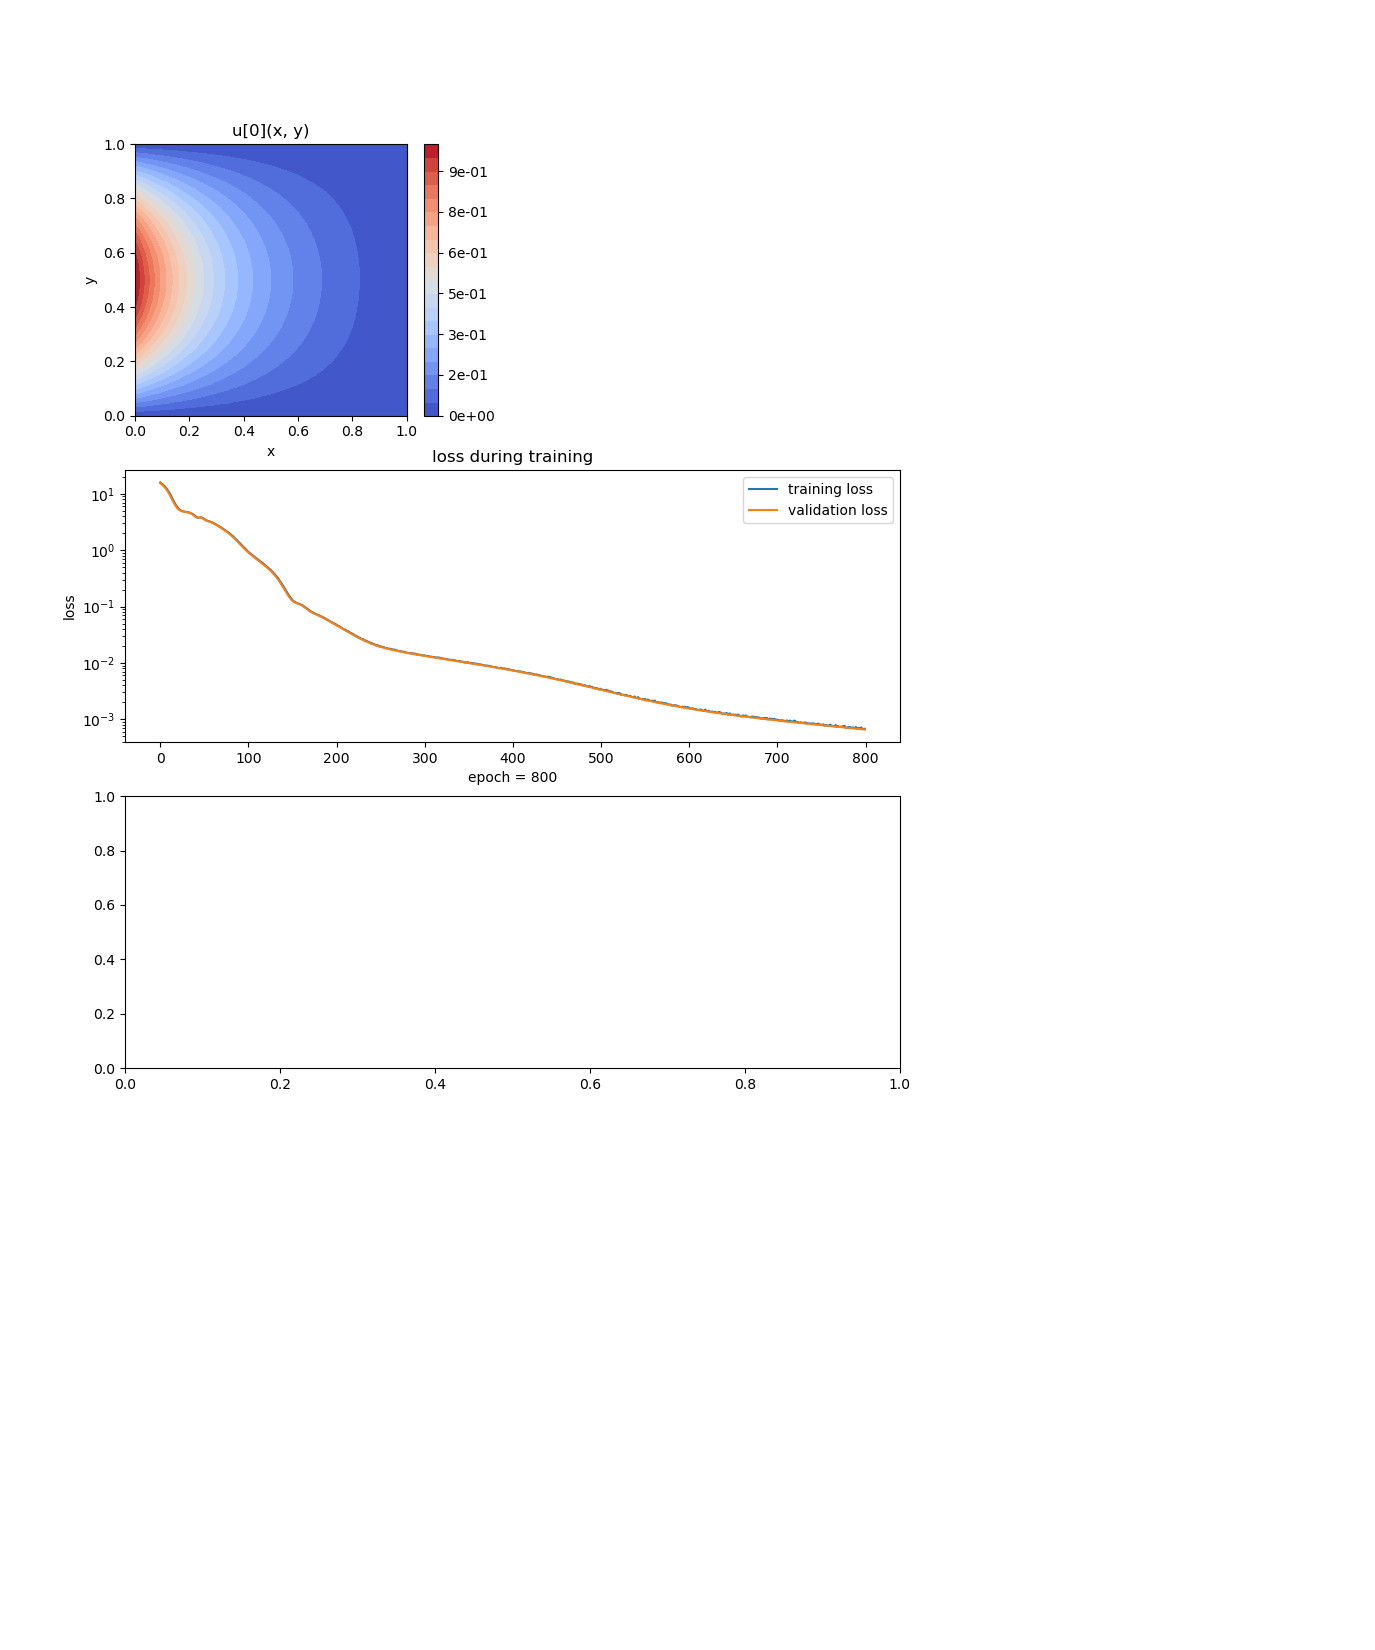

KeyboardInterrupt: 

In [7]:
# Define the PDE system
# There's only one (Laplace) equation in the system, so the function maps (u, x, y) to a single entry
laplace = lambda u, x, y: [diff(u, x, order=2) + diff(u, y, order=2)]

# Define the boundary conditions
# There's only one function to be solved for, so we only have a single condition
conditions = [
    DirichletBVP2D(
        x_min=0, x_min_val=lambda y: torch.sin(np.pi*y), 
        x_max=1, x_max_val=lambda y: 0, 
        y_min=0, y_min_val=lambda x: 0, 
        y_max=1, y_max_val=lambda x: 0,
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets_laplace_tanh = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=(32,32))
]

# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(1, 1))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver1 = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets_laplace_tanh,
    train_generator=Generator2D((64, 64), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((64, 64), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver1.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_tanh = solver1.get_solution()

In [ ]:
from scipy.interpolate import interp2d

# f will be a function with two arguments (x and y coordinates),
# but those can be array_like structures too, in which case the
# result will be a matrix representing the values in the grid 
# specified by those arguments


In [ ]:
xs = np.linspace(0, 1, 501)
ts = np.linspace(0, 1, 501)
xx, tt = np.meshgrid(xs, ts)

solution_analytical = lambda x, t: np.sin(np.pi*t)*np.sinh(np.pi*(1-x))/(np.sinh(np.pi))
sol_ana = solution_analytical(xx, tt)
sol_net = solution_tanh(xx, tt, to_numpy=True)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the analytical solution in the first subplot
im1 = axs[0].imshow(sol_net, extent=[min(xs), max(xs), min(ts), max(ts)], origin="lower")
axs[0].set_title('PINN Solution')

# Plot the analytical solution in the second subplot
im2 = axs[1].imshow(sol_ana, extent=[min(xs), max(xs), min(ts), max(ts)], origin="lower")
axs[1].set_title('Analytic Solution')

# Show the positions of the sample points in both subplots, just to have some reference
axs[0].scatter(xx, tt, 500, facecolors='none')
axs[1].scatter(xx, tt, 500, facecolors='none')

# Add a colorbar to the figure
fig.colorbar(im1, ax=axs)

# Show the figure
plt.show()

## Sine

In [ ]:
# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets_laplace_sin = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=(32,32),actv = SinActv)
]

# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(1, 1))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver2 = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets_laplace_sin,
    train_generator=Generator2D((64, 64), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((64, 64), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver2.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_sin = solver2.get_solution()

## Sigmoid

In [ ]:
# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets_laplace_sigmoid = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=(32,32),actv = torch.nn.Sigmoid)
]

# Define the monitor callback
monitor=Monitor2D(check_every=1000, xy_min=(0, 0), xy_max=(1, 1))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver3 = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets_laplace_sigmoid,
    train_generator=Generator2D((64, 64), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((64, 64), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver3.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_sigmoid = solver3.get_solution()

## Swish

In [ ]:
# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets_laplace_swish = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=(32,32),actv = Swish)
]

# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(1, 1))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver4 = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets_laplace_swish,
    train_generator=Generator2D((64, 64), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((64, 64), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver4.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_swish = solver4.get_solution()

In [ ]:
loss_tanh = solver1.metrics_history
loss_sine = solver2.metrics_history
loss_sigmoid = solver3.metrics_history
loss_swish = solver4.metrics_history

plt.figure()
plt.plot(loss_tanh['valid_loss'], label='Tanh')
plt.plot(loss_sine['valid_loss'], label='Sine')
plt.plot(loss_sigmoid['valid_loss'], label='Sigmoid')
plt.plot(loss_swish['valid_loss'], label='Swish')
plt.yscale('log')
plt.title('loss during training with different activation functions')
plt.xlabel('Laplace Equation',y=-0.2)
plt.legend()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d  import Axes3D
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title=''):
    fig  = plt.figure(figsize=(16, 8))
    ax   = Axes3D(fig)
    surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=1, alpha=0.8, cmap='hot')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    fig.suptitle(title)
    ax.set_proj_type('ortho')
    plt.show()

### PDE Example 2: 1-D Heat Equation

Here we solve 1-D heat equation:

$$
\frac{\partial u}{\partial t} - k \frac{\partial^2 u}{\partial x^2} = 0
$$

with an initial condition and 2 Neumann boundary on each end:

$$
u(x, t)\bigg|_{t=0} = \sin(\pi x) \\
\frac{\partial u(x, t)}{\partial x}\bigg|_{x=0} = \pi\exp(-k\pi^2 t) \\
\frac{\partial u(x, t)}{\partial x}\bigg|_{x=1} = -\pi\exp(-k\pi^2 t)
$$

The analytical solution is:

$$
u(x, t) = \sin(\pi \frac{x}{L}) \exp(\frac{-k \pi^2 t}{L^2})
$$

Since we are still solving in a 2-D space ($x$ and $t$), we will still be using `solve2D`. We use a `IBVP1D` condition to enforce our initial and boundary condition. The arguments `t_min_val`, `x_min_prime`, and `x_max_prime` correspond to $u(x, t)\bigg|_{t=0}$, $\displaystyle\frac{\partial u(x, t)}{\partial x}\bigg|_{x=0}$ and $\displaystyle\frac{\partial u(x, t)}{\partial x}\bigg|_{x=1}$.

In [ ]:
from neurodiffeq.conditions import IBVP1D 
from neurodiffeq.pde import make_animation

In [ ]:
k, L, T = 0.3, 2, 3
# Define the PDE system
# There's only one (heat) equation in the system, so the function maps (u, x, y) to a single entry
heat = lambda u, x, t: [
    diff(u, t) - k * diff(u, x, order=2)
]

# Define the initial and boundary conditions
# There's only one function to be solved for, so we only have a single condition object
conditions = [
    IBVP1D(
        t_min=0, t_min_val=lambda x: torch.sin(np.pi * x / L),
        x_min=0, x_min_prime=lambda t:  np.pi/L * torch.exp(-k*np.pi**2*t/L**2),
        x_max=L, x_max_prime=lambda t: -np.pi/L * torch.exp(-k*np.pi**2*t/L**2)
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets_heat_tanh = [
    FCNN(n_input_units=2, hidden_units=(32, 32))
]


# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(L, T))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver11 = Solver2D(
    pde_system=heat,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(L, T),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets_heat_tanh,
    train_generator=Generator2D((64, 64), (0, 0), (L, T), method='equally-spaced-noisy'),
    valid_generator=Generator2D((64, 64), (0, 0), (L, T), method='equally-spaced'),
)

# Fit the neural network
solver11.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_heat1 = solver11.get_solution()

In [ ]:
xs = np.linspace(0, 2, 201)
ts = np.linspace(0, 3, 301)
xx, tt = np.meshgrid(xs, ts)

solution_analytical_heat = lambda x, t: np.sin(np.pi*x/2)*np.exp(- 0.3 * np.pi * np.pi * t/4)
sol_ana = solution_analytical_heat(xx, tt)
sol_net = solution_heat1(xx, tt, to_numpy=True)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the analytical solution in the first subplot
im1 = axs[0].imshow(sol_net, extent=[min(xs), max(xs), min(ts), max(ts)], origin="lower")
axs[0].set_title('PINN Solution')

# Plot the analytical solution in the second subplot
im2 = axs[1].imshow(sol_ana, extent=[min(xs), max(xs), min(ts), max(ts)], origin="lower")
axs[1].set_title('Analytic Solution')

# Show the positions of the sample points in both subplots, just to have some reference
axs[0].scatter(xx, tt, 500, facecolors='none')
axs[1].scatter(xx, tt, 500, facecolors='none')

# Add a colorbar to the figure
fig.colorbar(im1, ax=axs)

# Show the figure
plt.show()

In [ ]:
# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets_heat_sin = [
    FCNN(n_input_units=2, hidden_units=(32, 32),actv=SinActv)
]


# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(L, T))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver22 = Solver2D(
    pde_system=heat,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(L, T),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets_heat_sin,
    train_generator=Generator2D((64, 64), (0, 0), (L, T), method='equally-spaced-noisy'),
    valid_generator=Generator2D((64, 64), (0, 0), (L, T), method='equally-spaced'),
)

# Fit the neural network
solver22.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_heat2 = solver22.get_solution()

In [ ]:
# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets_heat_sigmoid = [
    FCNN(n_input_units=2, hidden_units=(32, 32),actv=torch.nn.Sigmoid)
]


# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(L, T))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver33 = Solver2D(
    pde_system=heat,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(L, T),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets_heat_sigmoid,
    train_generator=Generator2D((64, 64), (0, 0), (L, T), method='equally-spaced-noisy'),
    valid_generator=Generator2D((64, 64), (0, 0), (L, T), method='equally-spaced'),
)

# Fit the neural network
solver33.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_heat3 = solver33.get_solution()

In [ ]:
# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets_heat_swish = [
    FCNN(n_input_units=2, hidden_units=(32, 32),actv=Swish)
]


# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(L, T))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver44 = Solver2D(
    pde_system=heat,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(L, T),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets_heat_swish,
    train_generator=Generator2D((64, 64), (0, 0), (L, T), method='equally-spaced-noisy'),
    valid_generator=Generator2D((64, 64), (0, 0), (L, T), method='equally-spaced'),
)

# Fit the neural network
solver44.fit(max_epochs=5000, callbacks=[monitor_callback])

# Obtain the solution
solution_heat4 = solver44.get_solution()

In [ ]:
loss_tanh2 = solver11.metrics_history
loss_sine2 = solver22.metrics_history
loss_sigmoid2 = solver33.metrics_history
loss_swish2 = solver44.metrics_history

plt.figure()
plt.plot(loss_tanh2['valid_loss'], label='Tanh')
plt.plot(loss_sine2['valid_loss'], label='Sine')
plt.plot(loss_sigmoid2['valid_loss'], label='Sigmoid')
plt.plot(loss_swish2['valid_loss'], label='Swish')
plt.yscale('log')
plt.title('loss during training with different activation functions')
plt.xlabel('Heat Equation',y=-0.2)
plt.legend()
plt.show()

### PDE Example 2: 1-D Wave Equation

Consider a 1-D wave equation with a Dirichlet boundary condition:

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2} = 0
$$

for $(x, y) \in [0, 1] \times [0, 1]$

s.t.

$$
u(x, t)\bigg|_{x=0} = \sin(ct) \\
u(x, t)\bigg|_{x=1} = \cos(1)\sin(ct) \\
$$

with some initial conditions:

$$
u(x, t)\bigg|_{t=0} = 0 \\
\frac{\partial u(x, t)}{\partial t}\bigg|_{t=0} = c\cos(x)
$$

The analytical solution is:

$$
u(x, t) = \cos(x)\sin(ct)
$$

Since we are still solving in a 2-D space ($x$ and $t$), we will still be using `solve2D`. We use a `IBVP1D` condition to enforce our initial and boundary condition. The arguments `x_min_val`, `x_max_val`, `t_min_value` and `t_min_prime` correspond to $u(x, t)\bigg|_{x=0}$, $u(x, t)\bigg|_{x=1}$, $u(x, t)\bigg|_{t=0}$ and $\displaystyle\frac{\partial u(x, t)}{\partial t}\bigg|_{t=0}$.